# Image Captioning:
## The Project Includes the following stages:
### 1. Preprocessing the inputs extracted from the flickr8k dataset (Images, captions).
### 2. Images feature extraction using the VGG16 pre-trained model
### 3. Passing the features + inputs to an RNN architecture model for generating captions from images.


### 1. Preprocessing the inputs extracted from the flickr8k dataset (Images, captions).

In [97]:
#importing the required packages and dependencies
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from numpy import array
import pandas as pd
from tqdm import tqdm
import datetime as datetime
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import glob
import string
import cv2
import random
import imgaug.augmenters as iaa
from pathlib import Path
from pickle import dump, load
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import LSTM, Embedding, Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ModelCheckpoint, TensorBoard
from keras.layers import Add
from keras.preprocessing import sequence
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
from collections import Counter
tf.random.set_seed(3)

In [98]:
#Utility function for extracting text from a file as a string 
def extract_text(path):
    with open(path, "r") as file:
        text = file.read()
    return text

#Utility function for applying preprocessing and formatting the text in the datapath
def preprocess_and_format(text, input_dir):
    lines = text.strip().split("\n")
    result = []
    for i, line in enumerate(lines):
        filename, caption = line.strip().split(",", 1)
        caption = caption.translate(str.maketrans('','',string.punctuation)) #removing special characters from the caption
        caption = caption.strip().lower() #converting uppercase to lowercase letters
        result.append([1] + [input_dir + "/" + filename] +[caption])
    return result

#Utility function for extracting two dataframes (data dataframe, word frequency dataframe)
def create_dataframes(result):
    data_df = pd.DataFrame(result, columns = ["index", "filename", "captions"])
    data_df['captions_with_tags'] = data_df['captions'].apply(lambda text: '<START>' + text + '<END>')
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data_df["captions"])
    
    data_df["caption_word_count"] = data_df["captions"].apply(lambda x: len(x.split(" ")))

    words = []
    frequency = []

    for w,v in tokenizer.word_counts.items():
        words.append(w)
        frequency.append(v)

    word_count_df = pd.DataFrame({'word': words, 'frequency': frequency})

    word_count_df.sort_values('frequency', ascending=False, inplace=True, ignore_index=True)

    return data_df, word_count_df        

In [99]:
#Applying the previous utility functions

images_dir = "/kaggle/input/flickr8k/Images"
text_dir = "/kaggle/input/flickr8k/captions.txt"
text = extract_text(text_dir)
result = preprocess_and_format(text, images_dir)
data_df, word_count_df = create_dataframes(result)

In [100]:
data_df = data_df.drop(0)
data_df.head()

,index,filename,captions,captions_with_tags,caption_word_count
1,1,/kaggle/input/flickr8k/Images/1000268201_693b0...,a child in a pink dress is climbing up a set o...,<START>a child in a pink dress is climbing up ...,17
2,1,/kaggle/input/flickr8k/Images/1000268201_693b0...,a girl going into a wooden building,<START>a girl going into a wooden building<END>,7
3,1,/kaggle/input/flickr8k/Images/1000268201_693b0...,a little girl climbing into a wooden playhouse,<START>a little girl climbing into a wooden pl...,8
4,1,/kaggle/input/flickr8k/Images/1000268201_693b0...,a little girl climbing the stairs to her playh...,<START>a little girl climbing the stairs to he...,9
5,1,/kaggle/input/flickr8k/Images/1000268201_693b0...,a little girl in a pink dress going into a woo...,<START>a little girl in a pink dress going int...,12


In [101]:
word_count_df = word_count_df.drop(0)
word_count_df.head()

,word,frequency
1,in,18974
2,the,18418
3,on,10743
4,is,9345
5,and,8851


In [102]:
#Utility function for some data exploration
def data_analysis(data):
  filename = data_df.filename.values
  caption_count = Counter(filename).values()
  uni_filenames = np.unique(filename)
  print(f'Number of unique file names : {len(uni_filenames)}')
  print(f'Number of captions per image : {set(caption_count)}')
  print(f'All image have same number of captions: {all(caption_count)}')

data_analysis(data_df)

Number of unique file names : 8091
Number of captions per image : {5}
All image have same number of captions: True


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


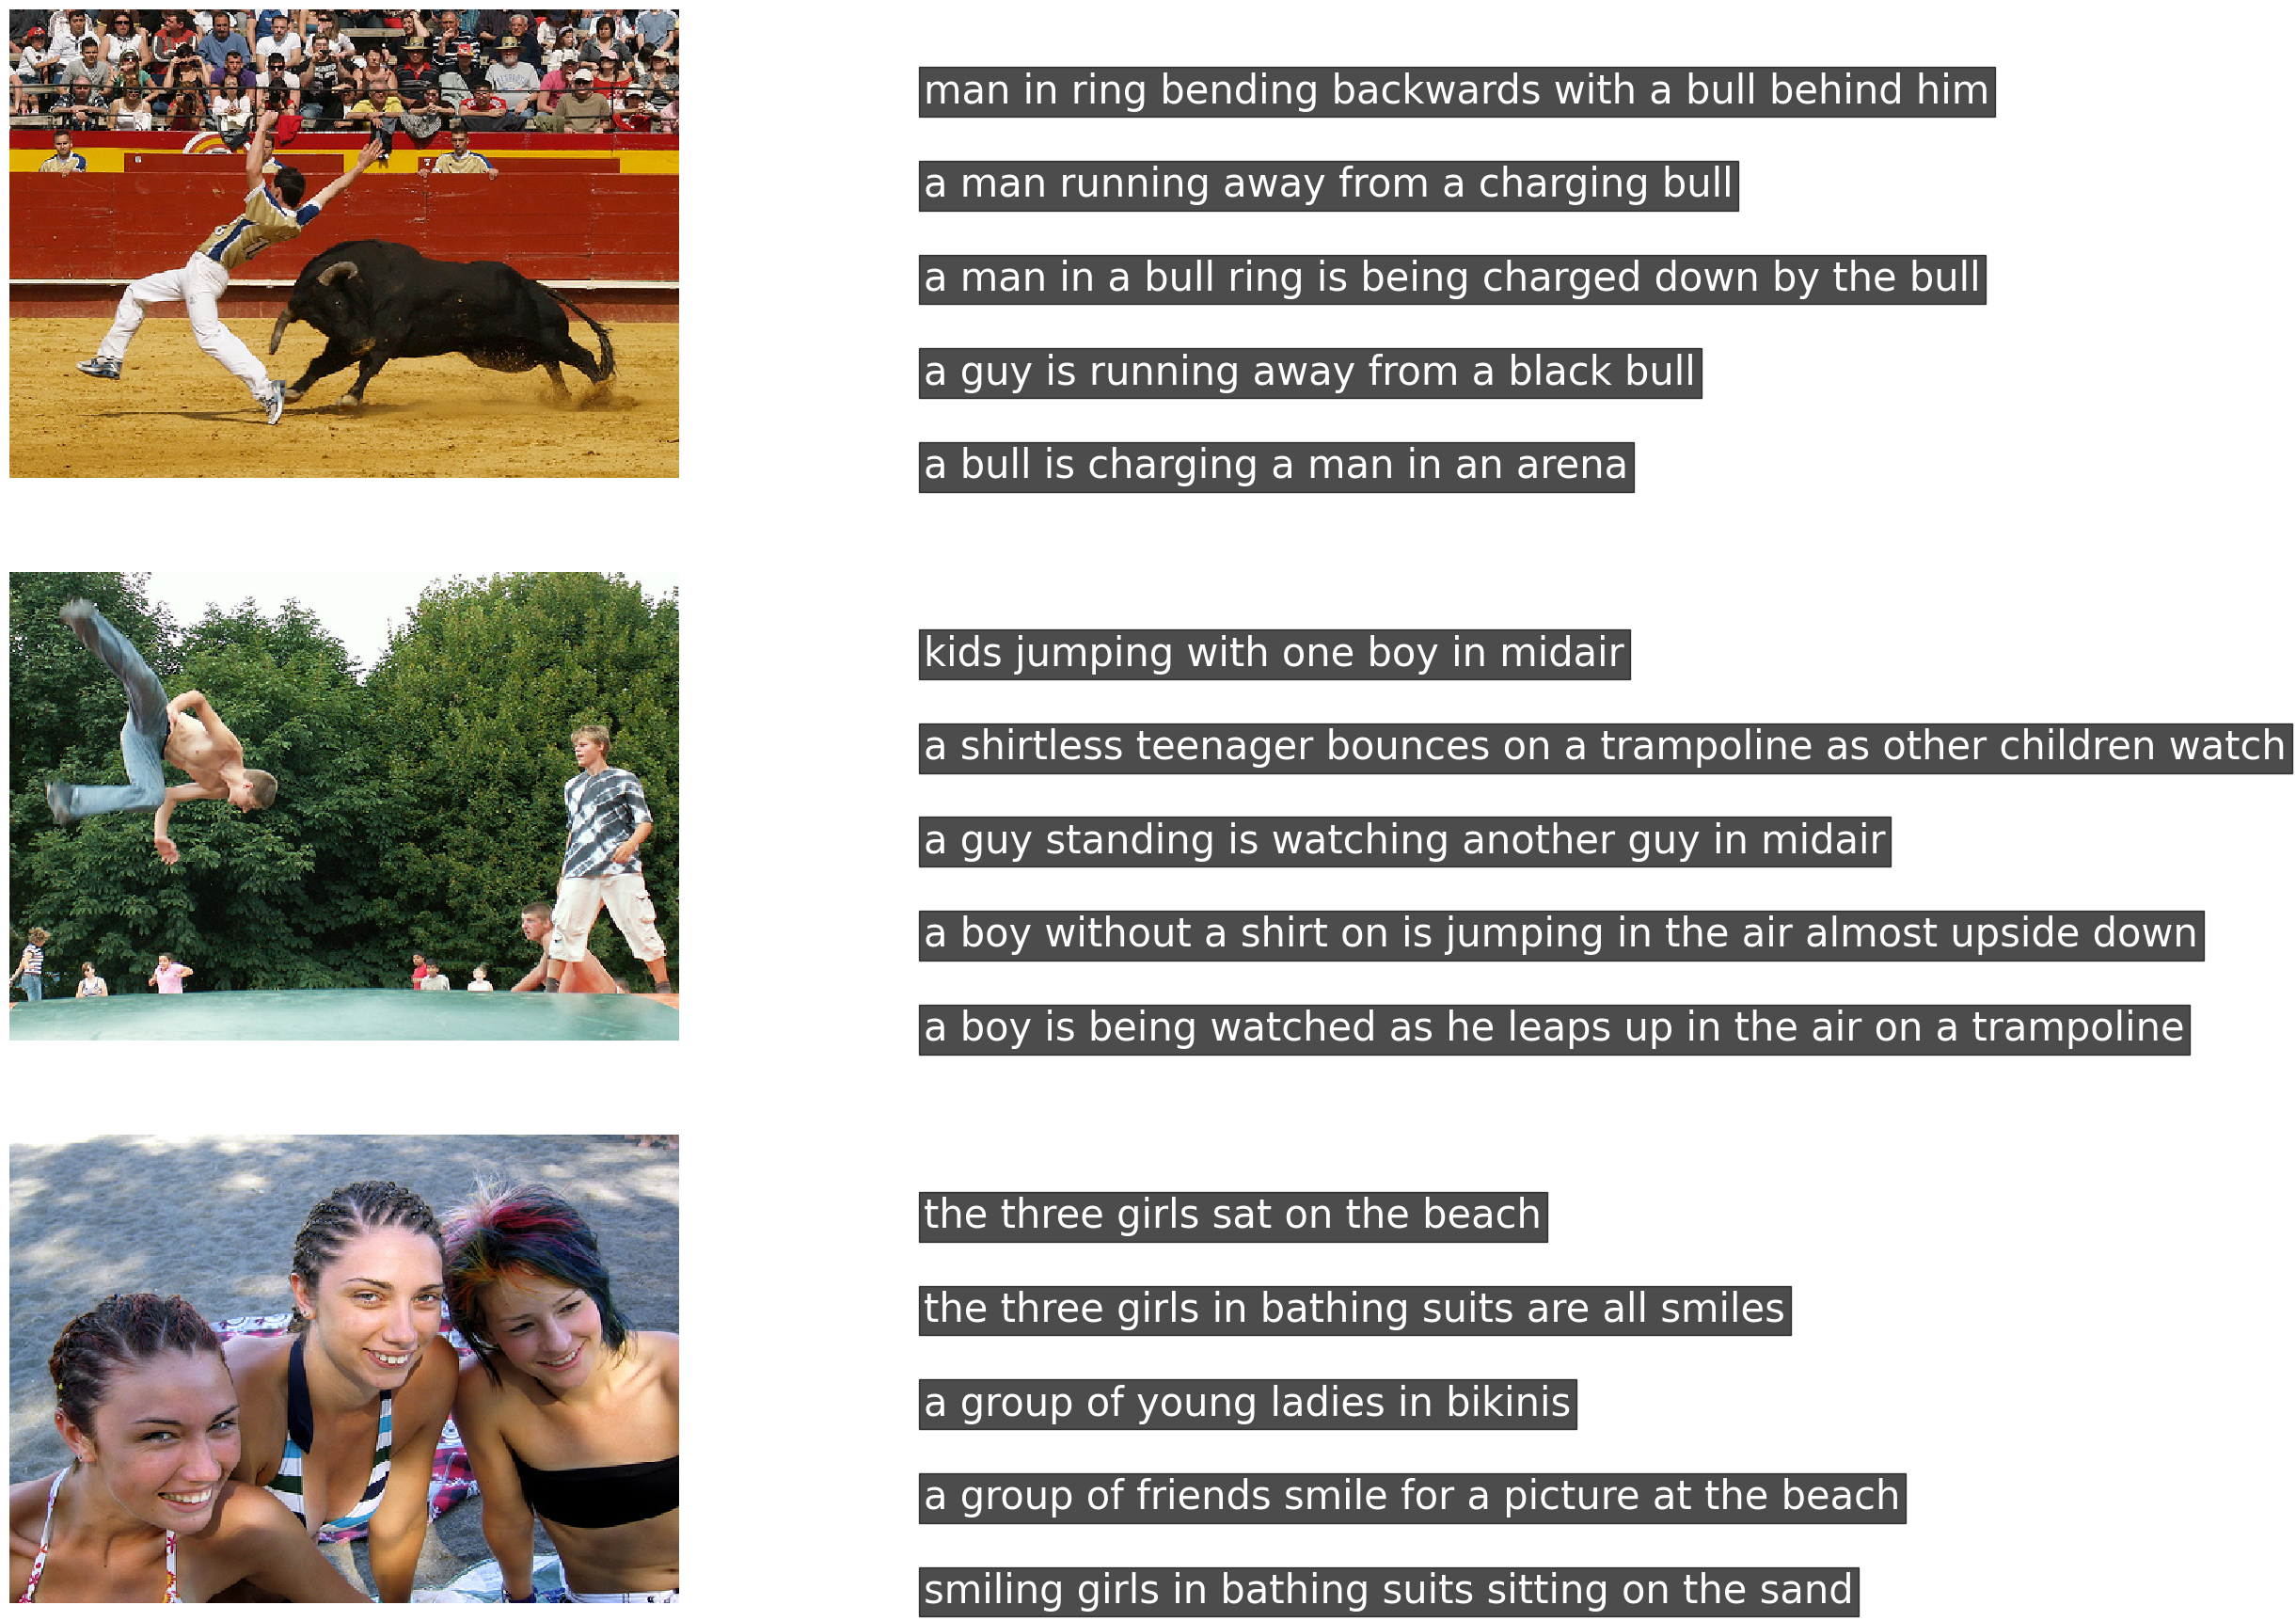

In [103]:
#utility functior for viewing some images with their corresponding captions
def image_caption_plotter(data):
  npic = 3
  target_size = (350, 500, 3)
  count = 1
  fig = plt.figure(figsize=(25, 22))

  for file in tqdm(random.sample(list(data['filename']), npic)):
    captions = list(data['captions'].loc[data['filename'] == file].values)
    image_load = load_img(file, target_size = target_size)

    ax = fig.add_subplot(npic, 2, count)
    ax.axis('off')
    ax.imshow(image_load, interpolation='nearest')
    count += 1

    ax = fig.add_subplot(npic, 2, count)
    ax.axis('off')
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
      ax.text(0, i, caption, fontsize = 30, fontfamily= 'fantasy', bbox=dict(facecolor='black', alpha=0.7), color='white')
    
    count += 1

    plt.grid(None)  

  plt.show()

 

image_caption_plotter(data_df)

In [114]:
#utility function for loading the train, dev, test image sets
def train_dev_test(images_lst, image_path):
    train_images_file = '/kaggle/input/flickr/Flickr_8k.trainImages.txt'
    train_images = images_lst[0:7592]
    train_filenames = train_images

    validation_images_file = '/kaggle/input/flickr/Flickr_8k.devImages.txt'
    validation_images = images_lst[7592:7842]
    validation_filenames = validation_images

    test_images_file = '/kaggle/input/flickr/Flickr_8k.testImages.txt'
    test_images = images_lst[7843: len(images_lst)]
    test_filenames = test_images
    return train_filenames, validation_filenames, test_filenames

In [115]:
image_path = '/kaggle/input/flickr8k/Images/'
images_list = glob.glob(image_path + '*.jpg')
train_filenames, dev_filenames, test_filenames = train_dev_test(images_list, image_path)
print(len(train_filenames))


7592


In [116]:
#Utility function for augmenting images
def image_augmentation(image_path):
    #Loading the image
    img= load_img(image_path, target_size= (224, 224))
    img = img_to_array(img)

    #augmentations initialization
    aug2 = iaa.Fliplr(1) 
    aug3 = iaa.Flipud(1)
    aug4 = iaa.Emboss(alpha=(1), strength=1)
    aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
    aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

    #the following makes the augmentation random on images. (different image may have different augmentations)
    a = np.random.uniform()
    if a<0.2:
         aug_image = aug2.augment_image(img)
    elif a<0.4:
         aug_image = aug3.augment_image(img)
    elif a<0.6:
         aug_image = aug4.augment_image(img)
    elif a<0.8:
         aug_image = aug5.augment_image(img)
    else:
         aug_image = aug6.augment_image(img) 

    return img, aug_image


In [117]:
#Extract image-to-captions mapping
def caption_mappings(train_filenames, test_filenames, data_df):
    train_caption_mapping = {}
    for file in tqdm(train_filenames):
        train_caption_mapping[file]= list(data_df.loc[data_df['filename'] == file].captions_with_tags)

    test_caption_mapping = {}
    for file in tqdm(test_filenames):
        test_caption_mapping[file]= list(data_df.loc[data_df['filename'] == file].captions_with_tags)
    
    return train_caption_mapping, test_caption_mapping

In [118]:
train_caption_mapping, test_caption_mapping = caption_mappings(train_filenames, test_filenames, data_df)

100%|██████████| 248/248 [00:01<00:00, 234.30it/s]


In [119]:
# Utility function for extracting features from images
def Feature_extractor(filenames, model):
    encoding = {}
    aug_filenames = []

    for file in tqdm(filenames):
        image, aug_image = image_augmentation(file)

        # Preprocessing inputs with correct dimensions
        image = preprocess_input(cv2.resize(image, (224, 224)))
        aug_image = preprocess_input(cv2.resize(aug_image, (224, 224)))

        # Extracting features for both image and aug_image
        feature_vector = model(np.expand_dims(image, axis=0))
        aug_feature_vector = model(np.expand_dims(aug_image, axis=0))

        # Reshaping features 
        feature_vector = np.reshape(feature_vector, (feature_vector.shape[1],))
        aug_feature_vector = np.reshape(aug_feature_vector, (aug_feature_vector.shape[1],))

        # Add an image path to the augmented image
        aug_path = file[:-4] + '_aug.jpg'    
        saved_path = '/kaggle/working/output/Aug_Images/' + aug_path.split('/')[-1]

        # Saving the features in the encoding dictionary
        encoding[file] = feature_vector
        encoding[saved_path] = aug_feature_vector
        aug_filenames.append(saved_path)

        # Map augmented image to captions
        train_caption_mapping[saved_path] = train_caption_mapping[file]

    global train_filenames
    train_filenames += aug_filenames

    return encoding  # Dict object containing all images and aug_images with their feature vectors


In [120]:
model = VGG16(weights= 'imagenet', include_top= True)
model_new = Model(model.input, model.layers[-2].output)
encodings = Feature_extractor(train_filenames, model_new)

100%|██████████| 7592/7592 [1:19:22<00:00,  1.59it/s]


In [122]:
print(len(encodings))

15184


In [ ]:
all_train_captions = set()
for _, caption_lst in tqdm(train_caption_mapping.items()):
    for caption in caption_lst:
        all_train_captions.add(caption)

all_test_captions = set()
for _, caption_lst in tqdm(test_caption_mapping.items()):
    for caption in caption_lst:
        all_test_captions.add(caption)    

In [ ]:
train_tokenizer = Tokenizer(oov_token = '<UNK>')
train_tokenizer.fit_on_texts(all_train_captions)
words = []
frequency = []
for word,freq in tqdm(train_tokenizer.word_counts.items()):
  words.append(word)
  frequency.append(freq)
df_wc_train = pd.DataFrame({'word': words, 'frequency': frequency}) 
df_wc_train.sort_values('frequency', ascending=False, inplace=True, ignore_index=True)

In [ ]:
ixtoword = dict((index, word) for word, index in train_tokenizer.word_index.items())
wordtoix = train_tokenizer.word_index
max_length = max(map(lambda caption: len(caption.split()), all_train_captions))
vocab_size = len(wordtoix)+1         

In [ ]:
def dataset_loader(tokenizer, image_caption_mapping, image_features, max_length, images_per_batch, vocab_size):
    image_feature, input_seq, output_seq = list(), list(), list()
    image_count=0   
    while 1:                                                                                             
        for image_path, captions in image_caption_mapping.items():
            image_count+=1
            feature = image_features[image_path]
            sequences = tokenizer.texts_to_sequences(captions)
            for seq in sequences:
              for i in range(1, len(seq)):
                  in_seq, out_seq = seq[:i], seq[i]                                                       # split into input and output pair
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]                                  # pad input sequence
                  out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]           # encode output sequence
                  image_feature.append(feature)
                  input_seq.append(in_seq)
                  output_seq.append(out_seq)
            if image_count==images_per_batch:                                                             # yield the batch data
                yield [[array(image_feature), array(input_seq)], array(output_seq)]
                image_feature, input_seq, output_seq = list(), list(), list()
                image_count=0

In [ ]:
embeddings_index = {} 

f = open('/kaggle/input/flickr/glove.6B.200d.txt', encoding="utf-8")



for line in tqdm(f):

    values = line.split()

    word = values[0]

    coefs = np.asarray(values[1:], dtype='float32')

    embeddings_index[word] = coefs

f.close()

print(f'\n Number of words in glove vector: {len(embeddings_index)}')

In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():

    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector

        

embedding_matrix.shape        

In [ ]:
input_image = Input(shape=(4096, ), name='Image_Feature_input')

fe1 = Dropout(0.5, name='Dropout_image')(input_image)

fe2 = Dense(256, activation='relu', name='Activation_Encoder')(fe1)

input_text = Input(shape=(max_length,), name='Text_input')

se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix], trainable=False, name='Text_Feature')(input_text)

se2 = Dropout(0.5, name='Dropout_text')(se1)

se3 = LSTM(256, name='LSTM')(se2)

decoder1 = Add(name='Add')([fe2, se3])

decoder2 = Dense(256, activation='relu', name='Activation_Decoder')(decoder1)

output = Dense(vocab_size, activation='softmax',name='Output')(decoder2)

model = Model(inputs=[input_image, input_text], outputs=output)
Model 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath = 'model-ep{epoch:03d}-loss{loss:.3f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

log_dir = "/kaggle/working/output/logs/fit/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = TensorBoard(log_dir = log_dir, histogram_freq=1)

In [ ]:
number_pics_per_bath = 16

steps = len(train_caption_mapping)//number_pics_per_bath

learning_rate = 0.001



train_generator = dataset_loader(train_tokenizer, train_caption_mapping, train_features, max_length, number_pics_per_bath, vocab_size)

history = model.fit(train_generator, epochs=70, steps_per_epoch=steps, verbose=1, callbacks = [checkpoint, tensorboard])

In [ ]:
plt.figure(figsize=(30, 5))

plt.subplot(121)

plt.plot(history.history['loss'])

plt.plot(history.history['accuracy'])

plt.title('Model - Loss/Accuracy', fontsize=20)

plt.ylabel('Loss/Accuracy')

plt.xlabel('Epoch')

plt.legend(['Loss', 'Accuracy'], loc='upper left')